## Metrics
Add performance metrics evaluted on the test set to `wandb`

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import wandb
import matplotlib.pyplot as plt

# my modules
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
from sn_camels.camels.camels_dataset import *
from sn_camels.models.camels_models import get_architecture
from sn_camels.utils.test_model import test_model

/mnt/home/cpedersen/miniconda3/envs/wavelet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
""" Base script to test a scattering network on a CAMELs dataset """

epochs=100
lr=0.0038
batch_size=64
project_name="new_metrics_debug"
error=True # Predict errors?
model_type="o3_err" ## "sn" or "camels" for now
# hyperparameters
wd         = 0.0000175  #value of weight decay
dr         = 0.6    #dropout value for fully connected layers
hidden     = 5      #this determines the number of channels in the CNNs; integer larger than 1

seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

config = {"learning rate": lr,
                 "epochs": epochs,
                 "batch size": batch_size,
                 "network": model_type,
                 "dropout": dr,
                 "error": error,
                 "hidden": hidden,
                 "wd": wd,
                 "splits":splits}

## Initialise wandb
wandb.login()
wandb.init(project="%s" % project_name, entity="chris-pedersen",config=config)

## Check if CUDA available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False


cudnn.benchmark = True      #May train faster but cost more memory

############################## Set up training params #################################################
## camels path
camels_path="/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/"

# data parameters
fmaps      = ['maps_Mcdm.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = camels_path+"/params_IllustrisTNG.txt"

# training parameters
channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

## Set number of classes for scattering network to output
if error==True:
    sn_classes=12
else:
    sn_classes=6

# optimizer parameters
beta1 = 0.5
beta2 = 0.999
#######################################################################################################
#######################################################################################################

fmaps2 = camels_path+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)
# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):  
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_Mcdm.npy', maps)
del maps

# get training set
print('\nPreparing training set')
train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm, 
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True)

# get validation set
print('\nPreparing validation set')
valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm, 
                                         rot_flip_in_mem=rot_flip_in_mem,  verbose=True)    

# get test set
print('\nPreparing test set')
test_loader = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=rot_flip_in_mem,  verbose=True)

num_train_maps=len(train_loader.dataset.x)
wandb.config.update({"no. training maps": num_train_maps})

if model_type=="sn":
    ## First create a scattering network object
    scatteringBase = baseModelFactory( #creat scattering base model
        architecture='scattering',
        J=2,
        N=256,
        M=256,
        max_order=2,
        initialization="Tight-Frame",
        seed=234,
        learnable=False,
        lr_orientation=0.005,
        lr_scattering=0.005,
        skip=True,
        split_filters=True,
        filter_video=False,
        subsample=4,
        device=device,
        use_cuda=use_cuda
    )

    ## Now create a network to follow the scattering layers
    ## can be MLP, linear, or cnn at the moment
    ## (as in https://github.com/bentherien/ParametricScatteringNetworks/ )
    top = topModelFactory( #create cnn, mlp, linearlayer, or other
        base=scatteringBase,
        architecture="linear_layer",
        num_classes=sn_classes,
        width=5,
        average=True,
        use_cuda=use_cuda
    )

    ## Merge these into a hybrid model
    hybridModel = sn_HybridModel(scatteringBase=scatteringBase, top=top, use_cuda=use_cuda)
    model=hybridModel
    wandb.config.update({"learnable":scatteringBase.learnable,
                         "initialisation":scatteringBase.initialization,
                         "wavelet seed":scatteringBase.seed,
                         "learnable_parameters":model.countLearnableParams(),
                         "max_order":scatteringBase.max_order,
                         "skip":scatteringBase.skip,
                         "split_filters":scatteringBase.split_filters,
                         "subsample":scatteringBase.subsample,
                         "scattering_output_dims":scatteringBase.M_coefficient,
                         "n_coefficients":scatteringBase.n_coefficients,
                         "top_model":top.arch,
                         "spatial_average":top.average
                         })
    print("scattering layer + cnn set up")
else:
    print("setting up model %s" % model_type)
    model = get_architecture(model_type,hidden,dr,channels)
    wandb.config.update({"learnable_parameters":sum(p.numel() for p in model.parameters())})
model.to(device=device)

# wandb
wandb.watch(model, log_freq=1)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

# do a loop over all epochs
start = time.time()
for epoch in range(epochs):
    log_dic={}
    if model_type=="sn":
        wave_params=hybridModel.scatteringBase.params_filters
        orientations=wave_params[0].cpu().detach().numpy()
        xis=wave_params[1].cpu().detach().numpy()
        sigmas=wave_params[2].cpu().detach().numpy()
        slants=wave_params[3].cpu().detach().numpy()
        for aa in range(len(orientations)):
            log_dic["orientation_%d" % aa]=orientations[aa]
            log_dic["xi_%d" % aa]=xis[aa]
            log_dic["sigma_%d" % aa]=sigmas[aa]
            log_dic["slant_%d" % aa]=slants[aa]

    # train
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        bs   = x.shape[0]         #batch size
        x    = x.to(device)       #maps
        y    = y.to(device)[:,g]  #parameters
        p    = model(x)           #NN output
        y_NN = p[:,g]             #posterior mean
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        if error==True:
            e_NN = p[:,h]         #posterior std
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            train_loss2 += loss2*bs
        else:
            loss = torch.mean(torch.log(loss1))
        train_loss1 += loss1*bs
        points      += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = torch.log(train_loss1/points) 
    if error==True:
        train_loss+=torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    valid_loss, points = 0.0, 0
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            if error==True:    
                e_NN  = p[:,h]         #posterior std
                loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
                valid_loss2 += loss2*bs
            valid_loss1 += loss1*bs
            points     += bs

    
    valid_loss = torch.log(valid_loss1/points) 
    if error==True:
        valid_loss+=torch.log(valid_loss2/points)
    valid_loss = torch.mean(valid_loss).item()

    scheduler.step(valid_loss)
    log_dic["training_loss"]=train_loss
    log_dic["valid_loss"]=valid_loss
    wandb.log(log_dic)
            
    # verbose
    print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')
    print("")

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chris-pedersen (use `wandb login --relogin` to force relogin)


CUDA Available
Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000

Preparing training set
Found 1 channels
Reading data...
3.859e+09 < F(all|orig) < 1.963e+15
9.586 < F(all|resc)  < 15.293
-2.759 < F(all|norm) < 8.501

Preparing validation set
Found 1 channels
Reading data...
3.859e+09 < F(all|orig) < 1.963e+15
9.586 < F(all|resc)  < 15.293
-2.759 < F(all|norm) < 8.501

Preparing test set
Found 1 channels
Reading data...
3.859e+09 < F(all|orig) < 1.963e+15
9.586 < F(all|resc)  < 15.293
-2.759 < F(all|norm) < 8.501
setting up model o3_err
000 1.602e+01 2.982e+01 
001 1.106e+01 1.858e+01 
002 7.352e+00 -2.414e+00 
003 5.556e+00 -1.750e+00 
004 2.640e+00 -2.549e+00 
005 1.132e+00 -4.165e+00 
006 -1.069e+00 -4.987e+00 
007 -3.502e+00 -4.007e+00 
008 -4.211e+00 -4.860e+00 
009 -4.883e+00 -5.752e+00 
010 -5.222e+00 -4.014e+00 
011 -5.099e+00 -5.774e+00 
012 -5.568e+00 -6.011e+00 
013 -5.760e+00 -5.919e+00 
014 -5.945e+00 -5.667e+00 
015 -5.548e+00 -6.085e+00 
016 -5.820e+00

In [3]:
## Model performance metrics on test set
num_maps=test_loader.dataset.size
## Now loop over test set and print accuracy
# define the arrays containing the value of the parameters
params_true = np.zeros((num_maps,6), dtype=np.float32)
params_NN   = np.zeros((num_maps,6), dtype=np.float32)
errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

# get test loss
g = [0, 1, 2, 3, 4, 5]
test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
test_loss, points = 0.0, 0
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        bs    = x.shape[0]    #batch size
        x     = x.to(device)  #send data to device
        y     = y.to(device)  #send data to device
        p     = model(x)      #prediction for mean and variance
        y_NN  = p[:,:6]       #prediction for mean
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        if error==True:
            e_NN  = p[:,h]         #posterior std
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            test_loss2 += loss2*bs
        test_loss1 += loss1*bs
        test_loss = torch.log(test_loss1/points)
        if error==True:
            test_loss+=torch.log(test_loss2/points)
        test_loss = torch.mean(test_loss).item()

        #e_NN  = p[:,6:]       #prediction for error
        #loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
        #loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
        #test_loss1 += loss1*bs
        #test_loss2 += loss2*bs

        # save results to their corresponding arrays
        params_true[points:points+x.shape[0]] = y.cpu().numpy() 
        params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
        errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
        points    += x.shape[0]
test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
test_loss = torch.mean(test_loss).item()
print('Test loss = %.3e\n'%test_loss)

# de-normalize
## I guess these are the hardcoded parameter limits
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
params_true = params_true*(maximum - minimum) + minimum
params_NN   = params_NN*(maximum - minimum) + minimum
errors_NN   = errors_NN*(maximum - minimum)

test_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Error Omega_m = %.3f'%test_error[0])
print('Error sigma_8 = %.3f'%test_error[1])
print('Error A_SN1   = %.3f'%test_error[2])
print('Error A_AGN1  = %.3f'%test_error[3])
print('Error A_SN2   = %.3f'%test_error[4])
print('Error A_AGN2  = %.3f\n'%test_error[5])

if error:    
    mean_error = np.absolute(np.mean(errors_NN, axis=0))
    print('Bayesian error Omega_m = %.3f'%mean_error[0])
    print('Bayesian error sigma_8 = %.3f'%mean_error[1])
    print('Bayesian error A_SN1   = %.3f'%mean_error[2])
    print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
    print('Bayesian error A_SN2   = %.3f'%mean_error[4])
    print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])
 
    rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
    print('Relative error Omega_m = %.3f'%rel_error[0])
    print('Relative error sigma_8 = %.3f'%rel_error[1])
    print('Relative error A_SN1   = %.3f'%rel_error[2])
    print('Relative error A_AGN1  = %.3f'%rel_error[3])
    print('Relative error A_SN2   = %.3f'%rel_error[4])
    print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

#test_model(model,test_loader,device)

Test loss = -8.234e+00

Error Omega_m = 0.063
Error sigma_8 = 0.047
Error A_SN1   = 0.977
Error A_AGN1  = 1.170
Error A_SN2   = 0.416
Error A_AGN2  = 0.450

Bayesian error Omega_m = 0.003
Bayesian error sigma_8 = 0.000
Bayesian error A_SN1   = 0.048
Bayesian error A_AGN1  = 0.382
Bayesian error A_SN2   = 0.056
Bayesian error A_AGN2  = 0.237

Relative error Omega_m = 0.194
Relative error sigma_8 = 0.055
Relative error A_SN1   = 1.799
Relative error A_AGN1  = 1.757
Relative error A_SN2   = 0.525
Relative error A_AGN2  = 0.601



Text(0, 0.5, 'Predicted $A_\\mathrm{AGN2}$')

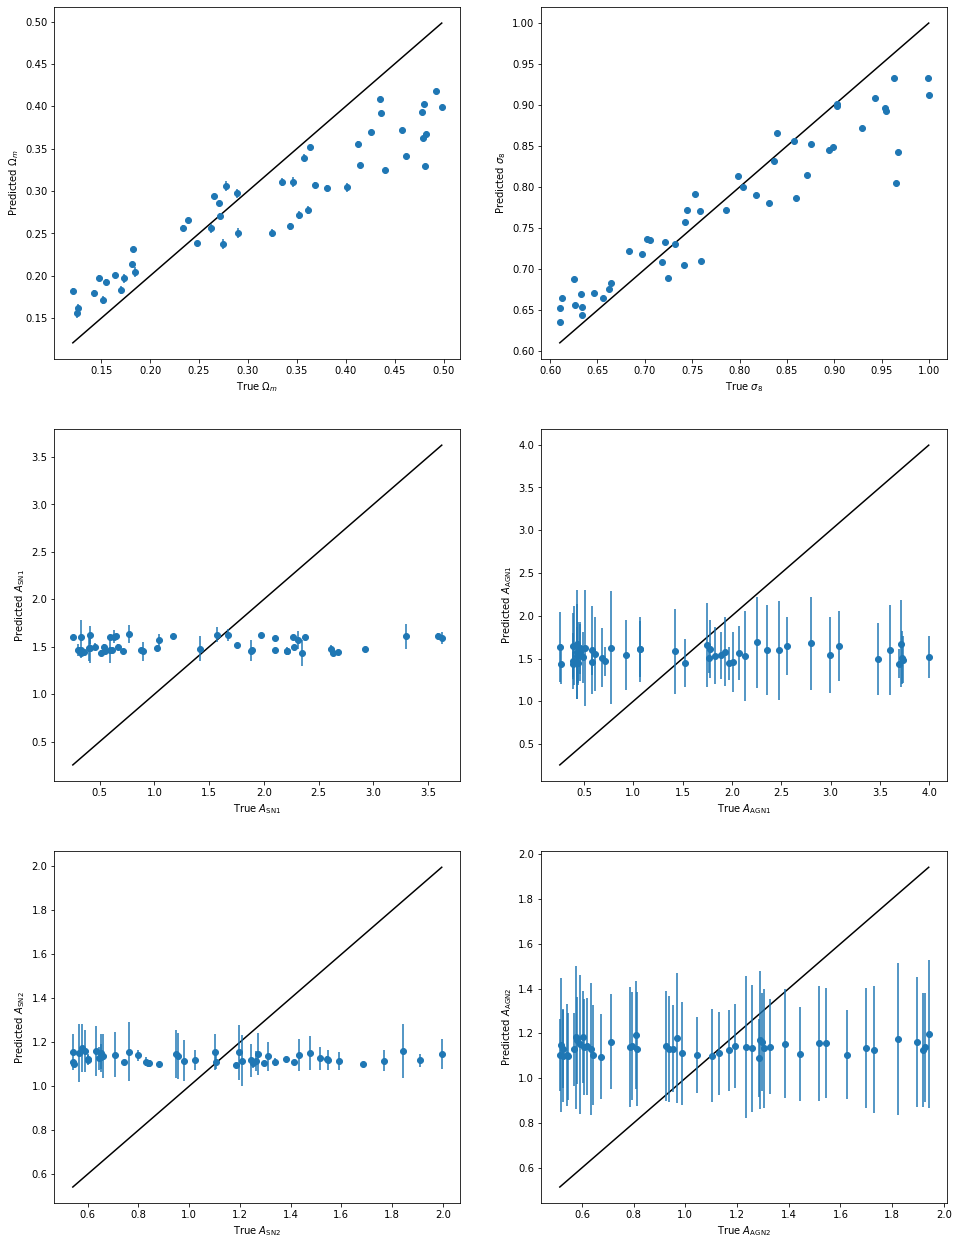

In [4]:
f, axarr = plt.subplots(3, 2, figsize=(16,22))
for aa in range(0,6,2):
    axarr[aa//2][0].plot(np.linspace(min(params_true[:,aa]),max(params_true[:,aa]),100),np.linspace(min(params_true[:,aa]),max(params_true[:,aa]),100),color="black")
    axarr[aa//2][0].errorbar(params_true[:,aa],params_NN[:,aa],errors_NN[:,aa],marker="o",ls="none")
    axarr[aa//2][1].plot(np.linspace(min(params_true[:,aa+1]),max(params_true[:,aa+1]),100),np.linspace(min(params_true[:,aa+1]),max(params_true[:,aa+1]),100),color="black")
    axarr[aa//2][1].errorbar(params_true[:,aa+1],params_NN[:,aa+1],errors_NN[:,aa+1],marker="o",ls="none")
    
axarr[0][0].set_xlabel(r"True $\Omega_m$")
axarr[0][0].set_ylabel(r"Predicted $\Omega_m$")

axarr[0][1].set_xlabel(r"True $\sigma_8$")
axarr[0][1].set_ylabel(r"Predicted $\sigma_8$")

axarr[1][0].set_xlabel(r"True $A_\mathrm{SN1}$")
axarr[1][0].set_ylabel(r"Predicted $A_\mathrm{SN1}$")

axarr[1][1].set_xlabel(r"True $A_\mathrm{AGN1}$")
axarr[1][1].set_ylabel(r"Predicted $A_\mathrm{AGN1}$")

axarr[2][0].set_xlabel(r"True $A_\mathrm{SN2}$")
axarr[2][0].set_ylabel(r"Predicted $A_\mathrm{SN2}$")

axarr[2][1].set_xlabel(r"True $A_\mathrm{AGN2}$")
axarr[2][1].set_ylabel(r"Predicted $A_\mathrm{AGN2}$")

In [ ]:
plt.plot(np.linspace(0.1,0.5,100),np.linspace(0.1,0.5,100),color="black")
plt.errorbar(params_true[:,0],params_NN[:,0],errors_NN[:,0],marker="o",ls="none")

In [ ]:
round(3/2)

In [ ]:
err[:,0]

In [ ]:
np.arange(len(params_true))

In [ ]:
params_true